<a href="https://colab.research.google.com/github/durgesh077/.colab_ssh/blob/main/getCells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [7]:
show=cv2_imshow

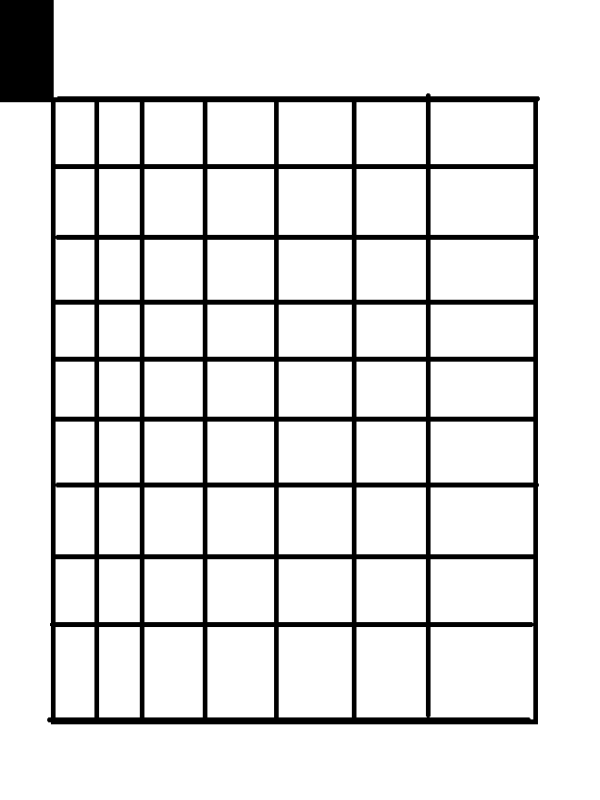

In [9]:
imgGrid=cv2.imread("grid3.png",cv2.IMREAD_GRAYSCALE)
imgGrid=cv2.resize(imgGrid,(600,800),interpolation=cv2.INTER_AREA)
marked=imgGrid.copy()
show(marked)

In [10]:
pxls=100
blackPxls=0.5

In [11]:
def preprocess(img,th=20):
  img=np.array(img,np.int32)
  shp=(400,400)
  for r in range(shp[0]):
    for c in range((img.shape[1])):
      if r ==0 and c==0:
        img[r][c]=img[r][c]>th
      elif r==0 and c:
        img[r][c]=img[r][c-1]+(img[r][c]>th)
      elif c==0 and r:
        img[r][c]=img[r-1][c]+(img[r][c]>th)
      else:
        img[r][c]=img[r-1][c]+img[r][c-1]-img[r-1][c-1]+(img[r][c]>th)
  for r in range(shp[0],img.shape[0]):
    for c in range((shp[1])):
      if r ==0 and c==0:
        img[r][c]=img[r][c]>th
      elif r==0 and c:
        img[r][c]=img[r][c-1]+(img[r][c]>th)
      elif c==0 and r:
        img[r][c]=img[r-1][c]+(img[r][c]>th)
      else:
        img[r][c]=img[r-1][c]+img[r][c-1]-img[r-1][c-1]+(img[r][c]>th)
  return img
def ratioBlack(img,r,c,h,w):
  h-=1
  w-=1
  sm=0
  if r ==0 and c==0:
    sm= img[h][w]
  elif r==0 and c:
    sm= img[h][c+w]- img[h][c-1]
  elif c==0 and r:
    sm= img[r+h][w]-img[r-1][w]
  else:
    sm= img[r+h][c+w]-img[r-1][c+w]-img[r+h][c-1]+img[r-1][c-1]
  total=((h+1)*(w+1))
  return 1-sm/total;

In [12]:
def convoluteShort(on,kernelShape):
  
  if on.shape[0]<200 or on.shape[1]<200:
    return 1

  y_len=kernelShape[0]
  x_len=kernelShape[1]
  y_from,x_from=0,0
  done=False
  for y in range(100):
    for x in range(100):
      res=ratioBlack(on,y,x,y_len,x_len)
      if res>blackPxls:
        y_from,x_from=(y+y_len,x+x_len)
        done=True
        break
    if done:
      break

  # try:
  while(ratioBlack(on,y_from,x_from,5,5)>blackPxls):
    x_from+=2
  x_from-=2
  while(1-ratioBlack(on,y_from,x_from,2,pxls)>blackPxls):
    y_from+=1
  return y_from,x_from
  # except:
  #   return 2


def nextHorizontalShort(on,y_prev,x_prev):
  y_prev+=30
  y_from=y_prev
  x_from=x_prev
  while(ratioBlack(on,y_from,x_from,5,pxls)>blackPxls):
      y_from+=1
  while(1-ratioBlack(on,y_from,x_from,5,pxls)>blackPxls):
      y_from+=1
  return y_from,x_from

def nextVerticalShort(on,y_prev,x_prev):
  x_prev+=30
  y_from=y_prev
  x_from=x_prev
  while(ratioBlack(on,y_from,x_from,pxls,5)>blackPxls):
    x_from+=1
  while(1-ratioBlack(on,y_from,x_from,pxls,5)>blackPxls):
      x_from+=1
  return y_from,x_from

In [13]:
def rotate(img,angle):
  rows = img.shape[0]
  cols = img.shape[1]

  img_center = (cols / 2, rows / 2)
  M = cv2.getRotationMatrix2D(img_center, angle, 1)

  rotated_image = cv2.warpAffine(img, M, (cols, rows),
                            borderMode=cv2.BORDER_CONSTANT,
                            borderValue=(255,255,255))
  return rotated_image

In [14]:
def getAllCells(hori,ver,on):
  starts=[]
  for y in range(len(hori)-1):
    for x in range(len(ver)-1):
      leftTop=hori[y][0],ver[x][1]
      rightEnd=hori[y+1][0],ver[x+1][1]
      starts.append((leftTop,rightEnd))
  return starts

In [15]:
for ii in np.arange(0,5):
    for i in [ii,-(ii)]:
      global done
      global marked
      done=False
      if i:
        timg=rotate(marked,i)
      else: 
        timg=marked
      img=preprocess(timg)
      try:
        leftEndpoint=convoluteShort(img,(30,30))
        horizontal=[leftEndpoint]
        vertical=[leftEndpoint]
        while(len(horizontal)<10):
          horizontal.append(nextHorizontalShort(img,horizontal[-1][0],horizontal[-1][1]))
        while(len(vertical)<8):
          vertical.append(nextVerticalShort(img,vertical[-1][0],vertical[-1][1]))
        done=True
        print("done")
        marked=timg
        break
      except:
        print(i)
        if ii==0:
          break
    if done :
      break
# print(done)
if not done:
  raise "not good image"

done


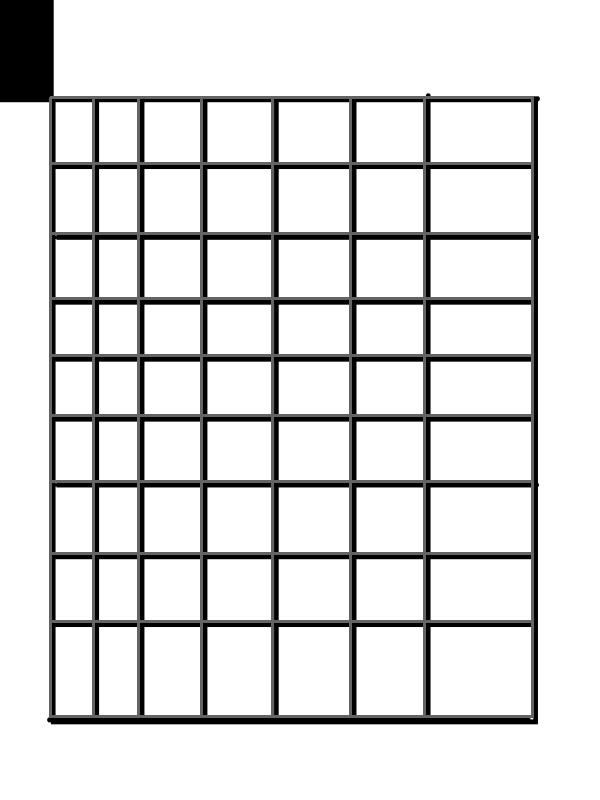

In [16]:
allBlocks=getAllCells(horizontal,vertical,marked)
cells=marked.copy()
for lt,rb in allBlocks:
  cells=cv2.rectangle(cells,lt[::-1],rb[::-1],100,2)
show(cells)